MOUNT DRIVE

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


SOME BASIC IMPORTS

In [2]:
# some basic imports
import math
import os
import re
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from random import sample
from PIL import Image

LOAD DATA FROM ZIP 

In [3]:
# unzip the dataset
try:
      !unzip '/content/gdrive/My Drive/road_segmentation/cil-road-segmentation-2021.zip'
      !mv training/training/* training
      !rm -rf training/training

except:
      print('Please upload a .zip file containing your datasets.')


Archive:  /content/gdrive/My Drive/road_segmentation/cil-road-segmentation-2021.zip
replace mask_to_submission.py? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
  inflating: training/training/groundtruth/satImage_001.png  
  inflating: training/training/groundtruth/satImage_002.png  
  inflating: training/training/groundtruth/satImage_003.png  
  inflating: training/training/groundtruth/satImage_004.png  
  inflating: training/training/groundtruth/satImage_005.png  
  inflating: training/training/groundtruth/satImage_006.png  
  inflating: training/training/groundtruth/satImage_007.png  
  inflating: training/training/groundtruth/satImage_008.png  
  inflating: training/training/groundtruth/satImage_009.png  
  inflating: training/training/groundtruth/satImage_010.png  
  inflating: training/training/groundtruth/satImage_011.png  
  inflating: training/training/groundtruth/satImage_012.png  
  inflating: training/training/groundtruth/satImage_013.png  
  inflating: training/training/groundtr

In [4]:
#load data into np array function
def load_all_from_path(path):
    # loads all HxW .pngs contained in path as a 4D np.array of shape (n_images, H, W, 3)
    # images are loaded as floats with values in the interval [0., 1.]
    return np.stack([np.array(Image.open(f)) for f in sorted(glob(path + '/*.png'))]).astype(np.float32) / 255.

#load data
imgs  = load_all_from_path(os.path.join('training', 'images'))
masks = load_all_from_path(os.path.join('training', 'groundtruth'))

PRE TRAIN DATA AUGMENTATION

In [5]:
import albumentations as A
from skimage import transform


#RANDOM ROTATE IMAGE IN STEP OF 90, THEN EITHER FLIP VERTICAL OR HORIZONTAL AUGMENT x9
def augment_data_random(imgs,masks):
 
    new_imgs = []
    new_masks = []
    for x, y in zip(imgs, masks):
        transformed1 =  A.Rotate(limit = (0, 90), interpolation=1, border_mode=cv2.BORDER_REFLECT, p= 1)(image = x,mask =  y)
        transformed2 =  A.Rotate(limit = (90, 180), interpolation=1, border_mode=cv2.BORDER_REFLECT, p= 1)(image = x,mask =  y)
        transformed3 =  A.Rotate(limit = (180, 270), interpolation=1, border_mode=cv2.BORDER_REFLECT, p= 1)(image = x,mask =  y)
        transformed4 =  A.Rotate(limit = (270, 360), interpolation=1, border_mode=cv2.BORDER_REFLECT, p= 1)(image = x,mask = y)

        transformed5 = A.HorizontalFlip(p=1)(image = transformed1['image'],mask =   transformed1['mask'])
        transformed6 = A.VerticalFlip(p=1)(image = transformed2['image'],mask =   transformed2['mask'])
        transformed7 = A.HorizontalFlip(p=1)(image = transformed3['image'],mask =   transformed3['mask'])
        transformed8 = A.VerticalFlip(p=1)(image = transformed4['image'],mask =   transformed4['mask'])

        new_imgs.append(x)
        new_imgs.append(transformed1['image'])
        new_imgs.append(transformed2['image'])
        new_imgs.append(transformed3['image'])
        new_imgs.append(transformed4['image'])
        new_imgs.append(transformed5['image'])
        new_imgs.append(transformed6['image'])
        new_imgs.append(transformed7['image'])
        new_imgs.append(transformed8['image'])

        new_masks.append(y)
        new_masks.append(transformed1['mask'])
        new_masks.append(transformed2['mask'])
        new_masks.append(transformed3['mask'])
        new_masks.append(transformed4['mask'])
        new_masks.append(transformed5['mask'])
        new_masks.append(transformed6['mask'])
        new_masks.append(transformed7['mask'])
        new_masks.append(transformed8['mask'])

    return  np.asarray(new_imgs), np.asarray(new_masks )





#AUGMENTED IMAGES AND MASKS
augmented_imgs, augmented_masks = augment_data_random(imgs, masks)

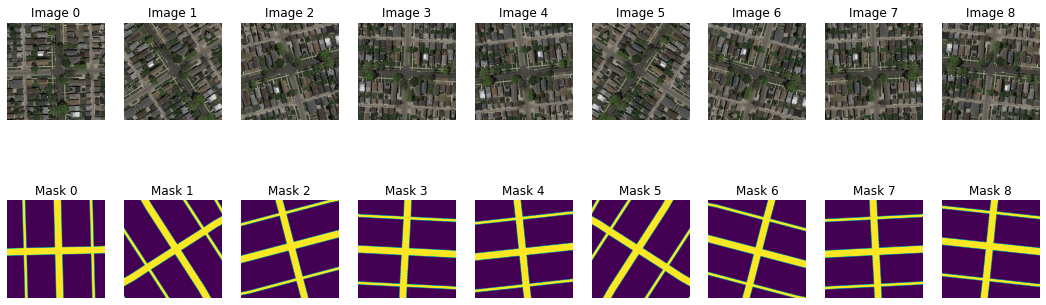

In [6]:
def show_first_n(imgs, masks, n=9):
    # visualizes the first n elements of a series of images and segmentation masks
    imgs_to_draw = min(n, len(imgs))
    fig, axs = plt.subplots(2, imgs_to_draw, figsize=(18.5, 6))
    for i in range(imgs_to_draw):
        axs[0, i].imshow(imgs[i])
        axs[1, i].imshow(masks[i])
        axs[0, i].set_title(f'Image {i}')
        axs[1, i].set_title(f'Mask {i}')
        axs[0, i].set_axis_off()
        axs[1, i].set_axis_off()
    plt.show()


show_first_n(augmented_imgs, augmented_masks)

TRAINING AND VALIDATION SPLIT

In [7]:
from sklearn.model_selection import train_test_split


train_data, val_data, train_masks, val_masks = train_test_split(imgs, masks, test_size=0.10, shuffle=True, random_state=42)


WEIGHT COMPUTATION FOR BALANCE

In [8]:
from sklearn.utils.class_weight import compute_class_weight

#returns (1- sum_percentage_label_0_per_image/n_images), (1- sum_percentage_label_0_per_image/n_images)
def number_of_label_01(masks):
  labels_1 = 0
  labels_0 = 0
  for mask in masks:
    h, w = mask.shape
    label_1 = np.sum(mask, axis = None)
    label_0 = h*w - label_1
    labels_1 += label_1/(h*w)
    labels_0 += label_0/(h*w)
  return np.array([(1 - labels_0/masks.shape[0]), (1 - labels_1/masks.shape[0])])

#like sklearn wieght class balanced i guess
def balanced_weights(masks):
  labels_1 = 0
  labels_0 = 0
  n_samples = masks.shape[0]*masks.shape[1]*masks.shape[2]
  for mask in masks:
    h, w = mask.shape
    label_1 = np.sum(mask, axis = None)
    label_0 = h*w - label_1
    labels_1 += label_1
    labels_0 += label_0
  return  np.array([(n_samples/(2*labels_0)), (n_samples/(2*labels_1))])
  

#class_weights  = number_of_label_01(train_masks)
class_weights = balanced_weights(train_masks)
class_weights

array([0.61629553, 2.64969564])

UTIL FUNCTIONS

In [9]:
# some constants
PATCH_SIZE = 16  # pixels per side of square patches
VAL_SIZE = 10  # size of the validation set (number of images)
CUTOFF = 0.25  # minimum average brightness for a mask patch to be classified as containing road


def show_first_n(imgs, masks, n=5):
    # visualizes the first n elements of a series of images and segmentation masks
    imgs_to_draw = min(5, len(imgs))
    fig, axs = plt.subplots(2, imgs_to_draw, figsize=(18.5, 6))
    for i in range(imgs_to_draw):
        axs[0, i].imshow(imgs[i])
        axs[1, i].imshow(masks[i])
        axs[0, i].set_title(f'Image {i}')
        axs[1, i].set_title(f'Mask {i}')
        axs[0, i].set_axis_off()
        axs[1, i].set_axis_off()
    plt.show()



#RETURNS LIST OF PATCHES AND LABELS FROM IMAGES
def image_to_patches(images, masks=None):
    # takes in a 4D np.array containing images and (optionally) a 4D np.array containing the segmentation masks
    # returns a 4D np.array with an ordered sequence of patches extracted from the image and (optionally) a np.array containing labels
    n_images = images.shape[0]  # number of images
    h, w = images.shape[1:3]  # shape of images
    assert (h % PATCH_SIZE) + (w % PATCH_SIZE) == 0  # make sure images can be patched exactly

    h_patches = h // PATCH_SIZE
    w_patches = w // PATCH_SIZE
    patches = images.reshape((n_images, h_patches, PATCH_SIZE, h_patches, PATCH_SIZE, -1))
    patches = np.moveaxis(patches, 2, 3)
    patches = patches.reshape(-1, PATCH_SIZE, PATCH_SIZE, 3)
    if masks is None:
        return patches

    masks = masks.reshape((n_images, h_patches, PATCH_SIZE, h_patches, PATCH_SIZE, -1))
    masks = np.moveaxis(masks, 2, 3)
    labels = np.mean(masks, (-1, -2, -3)) > CUTOFF  # compute labels
    labels = labels.reshape(-1).astype(np.float32)
    return patches, labels


def show_patched_image(patches, labels, h_patches=25, w_patches=25):
    # reorders a set of patches in their original 2D shape and visualizes them
    fig, axs = plt.subplots(h_patches, w_patches, figsize=(18.5, 18.5))
    for i, (p, l) in enumerate(zip(patches, labels)):
        # the np.maximum operation paints patches labeled as road red
        axs[i // w_patches, i % w_patches].imshow(np.maximum(p, np.array([l.item(), 0., 0.])))
        axs[i // w_patches, i % w_patches].set_axis_off()
    plt.show()


MODEL 

In [10]:
import torch
from torch import nn
from torch.utils.tensorboard import SummaryWriter
from tqdm.notebook import tqdm
import albumentations as A
import copy
from torch.optim.lr_scheduler import ReduceLROnPlateau
import gc

TRANSFORM FOR ONLINE AUGMENTATION OF TRAINING SET

In [11]:
train_transform = A.Compose(
    [   A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.Rotate(interpolation=1, border_mode=cv2.BORDER_REFLECT, p=0.5),
    ]
)

DATASET 

In [12]:
def np_to_tensor(x, device):
    # allocates tensors from np.arrays
    if device == 'cpu':
        return torch.from_numpy(x).cpu()
    else:
        return torch.from_numpy(x).contiguous().pin_memory().to(device=device, non_blocking=True)



class ImageDataset(torch.utils.data.Dataset):
    # dataset class that deals with loading the data and making it available by index.

    def __init__(self, imgs, masks, path, device, use_patches=True, resize_to=(400, 400), transform=None):
        self.path = path
        self.device = device
        self.use_patches = use_patches
        self.resize_to=resize_to
        self.transform = transform
        #self.x, self.y, self.n_samples = None, None, None
        #self._load_data()
        self.x, self.y = imgs, masks
        self.n_samples = len(self.x)
        if self.resize_to != (self.x.shape[1], self.x.shape[2]):  # resize images
            self.x = np.stack([cv2.resize(img, dsize=self.resize_to) for img in self.x], 0)
            self.y = np.stack([cv2.resize(mask, dsize=self.resize_to) for mask in self.y], 0)
        self.x = np.moveaxis(self.x, -1, 1)  # pytorch works with CHW format instead of HWC

        

    def _load_data(self):  # not very scalable, but good enough for now
        self.x = load_all_from_path(os.path.join(self.path, 'images'))
        self.y = load_all_from_path(os.path.join(self.path, 'groundtruth'))
        if self.use_patches:  # split each image into patches
            self.x, self.y = image_to_patches(self.x, self.y)
        elif self.resize_to != (self.x.shape[1], self.x.shape[2]):  # resize images
            self.x = np.stack([cv2.resize(img, dsize=self.resize_to) for img in self.x], 0)
            self.y = np.stack([cv2.resize(mask, dsize=self.resize_to) for mask in self.y], 0)
        self.x = np.moveaxis(self.x, -1, 1)  # pytorch works with CHW format instead of HWC
        self.n_samples = len(self.x)


    def _preprocess(self, x, y):
        # to keep things simple we will not apply transformations to each sample,
        # but it would be a very good idea to look into preprocessing 
        if self.transform is not None:
            transformed = self.transform(image=x, mask=y)
            x = transformed["image"]
            y = transformed["mask"]
        return x, y


    def __getitem__(self, item):
        return self._preprocess(np_to_tensor(self.x[item], self.device), np_to_tensor(self.y[[item]], self.device))
          

    def __len__(self):
        return self.n_samples


def show_val_samples(x, y, y_hat, segmentation=False):
    # training callback to show predictions on validation set
    imgs_to_draw = min(5, len(x))
    if x.shape[-2:] == y.shape[-2:]:  # segmentation
        fig, axs = plt.subplots(3, imgs_to_draw, figsize=(18.5, 12))
        for i in range(imgs_to_draw):
            axs[0, i].imshow(np.moveaxis(x[i], 0, -1))
            axs[1, i].imshow(np.concatenate([np.moveaxis(y_hat[i], 0, -1)] * 3, -1))
            axs[2, i].imshow(np.concatenate([np.moveaxis(y[i], 0, -1)]*3, -1))
            axs[0, i].set_title(f'Sample {i}')
            axs[1, i].set_title(f'Predicted {i}')
            axs[2, i].set_title(f'True {i}')
            axs[0, i].set_axis_off()
            axs[1, i].set_axis_off()
            axs[2, i].set_axis_off()
    else:  # classification
        fig, axs = plt.subplots(1, imgs_to_draw, figsize=(18.5, 6))
        for i in range(imgs_to_draw):
            axs[i].imshow(np.moveaxis(x[i], 0, -1))
            axs[i].set_title(f'True: {np.round(y[i]).item()}; Predicted: {np.round(y_hat[i]).item()}')
            axs[i].set_axis_off()
    plt.show()

TRAIN FUNCTION

In [13]:
def train(train_dataloader, eval_dataloader, model, loss_fn, metric_fns, optimizer, n_epochs, patience, scheduler):
    # training loop
    logdir = './tensorboard/net'
    writer = SummaryWriter(logdir)  # tensorboard writer (can also log images)

    history = {}  # collects metrics at the end of each epoch

    max_val_patch_acc = 0
    epochs_no_improve = 0

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        # initialize metric list
        metrics = {'loss': [], 'val_loss': []}
        for k, _ in metric_fns.items():
            metrics[k] = []
            metrics['val_'+k] = []

        pbar = tqdm(train_dataloader, desc=f'Epoch {epoch+1}/{n_epochs}')
        # training
        model.train()
        for (x, y) in pbar:
            optimizer.zero_grad()  # zero out gradients
            gc.collect()
            y_hat = model(x)  # forward pass
            loss = loss_fn(y_hat, y)
            loss.backward()  # backward pass
            optimizer.step()  # optimize weights

            # log partial metrics
            metrics['loss'].append(loss.item())
            for k, fn in metric_fns.items():
                metrics[k].append(fn(y_hat, y).item())
            pbar.set_postfix({k: sum(v)/len(v) for k, v in metrics.items() if len(v) > 0})

        # validation
        model.eval()
        with torch.no_grad():  # do not keep track of gradients
            for (x, y) in eval_dataloader:
                y_hat = model(x)  # forward pass
                loss = loss_fn(y_hat, y)
                
                # log partial metrics
                metrics['val_loss'].append(loss.item())
                for k, fn in metric_fns.items():
                    metrics['val_'+k].append(fn(y_hat, y).item())

        
        # summarize metrics, log to tensorboard and display
        history[epoch] = {k: sum(v) / len(v) for k, v in metrics.items()}
        for k, v in history[epoch].items():
          writer.add_scalar(k, v, epoch)
        print(' '.join(['\t- '+str(k)+' = '+str(v)+'\n ' for (k, v) in history[epoch].items()]))
        show_val_samples(x.detach().cpu().numpy(), y.detach().cpu().numpy(), y_hat.detach().cpu().numpy())


        #scheduler for learning rate update
        scheduler.step( sum(metrics['val_loss']) / len(metrics['val_loss']))
        curr_lr = optimizer.param_groups[0]['lr']
        print('learning rate')
        print(curr_lr)
        

        #early stopping
        val_patch_acc = sum(metrics['val_patch_acc']) / len(metrics['val_patch_acc'])
        if val_patch_acc > max_val_patch_acc:
          #Saving the model
          #if min_loss > loss.item():
              #min_loss = loss.item()
          best_model = copy.deepcopy(model.state_dict())
          print('saving model')
          epochs_no_improve = 0
          max_val_patch_acc = val_patch_acc

        else:
          epochs_no_improve += 1
          print('val_patch_acc not improving')
          # Check early stopping condition
          if epochs_no_improve == patience:
              print('Early stopping!' )
              model.load_state_dict(best_model)
              break



    print('Finished Training')
    # plot loss curves
    plt.plot([v['loss'] for k, v in history.items()], label='Training Loss')
    plt.plot([v['val_loss'] for k, v in history.items()], label='Validation Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()

GAN TRAIN FUNCTION

In [14]:
def gantrain(train_dataloader, eval_dataloader, modelD, modelG, loss_fn, metric_fns, optimizerD, optimizerG, n_epochs, patience, scheduler, batch_size):
    # training loop
    logdir = './tensorboard/net'
    writer = SummaryWriter(logdir)  # tensorboard writer (can also log images)

    history = {}  # collects metrics at the end of each epoch

    max_val_patch_acc = 0
    epochs_no_improve = 0

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        # initialize metric list
        metrics = {'loss': [], 'val_loss': []}
        for k, _ in metric_fns.items():
            metrics[k] = []
            metrics['val_'+k] = []

        pbar = tqdm(train_dataloader, desc=f'Epoch {epoch+1}/{n_epochs}')
        # training
        #modelD.train()
        #modelG.train()
        for (x, y) in pbar:

            # TRAIN DISCRIMINATOR
            optimizerD.zero_grad()  # zero out gradients
            gc.collect()

            real = modelD.forward(y, x)  # forward pass 1 with ground truth data
            real_label = torch.ones(batch_size, dtype = torch.float).to(device) # label of ones to desginate that the input is "real" (ground truth)
            real_loss = loss_fn(real, real_label)  # loss for the real part of the input
            real_loss.backward()  # backward pass

            generated_seg = modelG.forward(x)  # segmentations generated by our GAN
            fake = modelD(modelG(x), x)  # forward pass 2 with generated data
            fake_label = torch.zeros(batch_size, dtype = torch.float).to(device)  # label of zeroes to designate that the input is "fake" (generated by GAN)
            fake_loss = loss_fn(fake, fake_label)  # loss for the fake part of the input
            fake_loss.backward()  #backward pass

            loss = real_loss + fake_loss  # combining losses
            optimizerD.step()  # optimize weights

            # TRAIN GENERATOR
            optimizerG.zero_grad()  # zero out gradients
            gc.collect()

            new_output = modelD.forward(modelG(x), x)  # new output from our updated discriminator
            new_label = torch.ones(batch_size, dtype = torch.float).to(device)
            lossG = loss_fn(new_output, new_label)  # we look at the loss with 'real' labels as target, as we now want to train in an adversarial fashion.
            lossG.backward()  # backward pass

            optimizerG.step()  #optimize weights



            # log partial metrics
            metrics['loss'].append(loss.item())
            for k, fn in metric_fns.items():
                metrics[k].append(fn(generated_seg, y).item())
            pbar.set_postfix({k: sum(v)/len(v) for k, v in metrics.items() if len(v) > 0})

        # validation
        modelG.eval()
        with torch.no_grad():  # do not keep track of gradients
            for (x, y) in eval_dataloader:
                y_hat = modelG(x)  # forward pass
                loss = loss_fn(y_hat, y)
                
                # log partial metrics
                metrics['val_loss'].append(loss.item())
                for k, fn in metric_fns.items():
                    metrics['val_'+k].append(fn(y_hat, y).item())

        
        # summarize metrics, log to tensorboard and display
        history[epoch] = {k: sum(v) / len(v) for k, v in metrics.items()}
        for k, v in history[epoch].items():
          writer.add_scalar(k, v, epoch)
        print(' '.join(['\t- '+str(k)+' = '+str(v)+'\n ' for (k, v) in history[epoch].items()]))
        show_val_samples(x.detach().cpu().numpy(), y.detach().cpu().numpy(), y_hat.detach().cpu().numpy())


        #scheduler for learning rate update
        scheduler.step( sum(metrics['val_loss']) / len(metrics['val_loss']))
        curr_lr = optimizerG.param_groups[0]['lr']
        print('learning rate')
        print(curr_lr)
        

        #early stopping
        val_patch_acc = sum(metrics['val_patch_acc']) / len(metrics['val_patch_acc'])
        if val_patch_acc > max_val_patch_acc:
          #Saving the model
          #if min_loss > loss.item():
              #min_loss = loss.item()
          best_model = copy.deepcopy(modelG.state_dict())
          print('saving model')
          epochs_no_improve = 0
          max_val_patch_acc = val_patch_acc

        else:
          epochs_no_improve += 1
          print('val_patch_acc not improving')
          # Check early stopping condition
          if epochs_no_improve == patience:
              print('Early stopping!' )
              modelG.load_state_dict(best_model)
              break



    print('Finished Training')
    # plot loss curves
    plt.plot([v['loss'] for k, v in history.items()], label='Training Loss')
    plt.plot([v['val_loss'] for k, v in history.items()], label='Validation Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()

COMPOSITE TRAINING

In [15]:
def comptrain(train_dataloader, eval_dataloader, modelD, modelG, loss_fn_r, loss_fn_gan, metric_fns, optimizerD, optimizerG, n_epochs, patience, scheduler, batch_size):
    # training loop
    logdir = './tensorboard/net'
    writer = SummaryWriter(logdir)  # tensorboard writer (can also log images)

    history = {}  # collects metrics at the end of each epoch

    model = modelG
    optimizer = optimizerG

    max_val_patch_acc = 0
    epochs_no_improve = 0

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        # initialize metric list
        metrics = {'loss': [], 'val_loss': []}
        for k, _ in metric_fns.items():
            metrics[k] = []
            metrics['val_'+k] = []

        pbar = tqdm(train_dataloader, desc=f'Epoch {epoch+1}/{n_epochs}')
        # training
        model.train()
        for (x, y) in pbar:
            optimizer.zero_grad()  # zero out gradients
            gc.collect()
            y_hat = model(x)  # forward pass
            loss = loss_fn_r(y_hat, y)
            loss.backward()  # backward pass
            optimizer.step()  # optimize weights

            # log partial metrics
            metrics['loss'].append(loss.item())
            for k, fn in metric_fns.items():
                metrics[k].append(fn(y_hat, y).item())
            pbar.set_postfix({k: sum(v)/len(v) for k, v in metrics.items() if len(v) > 0})

        # validation
        model.eval()
        with torch.no_grad():  # do not keep track of gradients
            for (x, y) in eval_dataloader:
                y_hat = model(x)  # forward pass
                loss = loss_fn_r(y_hat, y)
                
                # log partial metrics
                metrics['val_loss'].append(loss.item())
                for k, fn in metric_fns.items():
                    metrics['val_'+k].append(fn(y_hat, y).item())

        
        # summarize metrics, log to tensorboard and display
        history[epoch] = {k: sum(v) / len(v) for k, v in metrics.items()}
        for k, v in history[epoch].items():
          writer.add_scalar(k, v, epoch)
        print(' '.join(['\t- '+str(k)+' = '+str(v)+'\n ' for (k, v) in history[epoch].items()]))
        show_val_samples(x.detach().cpu().numpy(), y.detach().cpu().numpy(), y_hat.detach().cpu().numpy())


        #scheduler for learning rate update
        scheduler.step( sum(metrics['val_loss']) / len(metrics['val_loss']))
        curr_lr = optimizer.param_groups[0]['lr']
        print('learning rate')
        print(curr_lr)
        

        #early stopping
        val_patch_acc = sum(metrics['val_patch_acc']) / len(metrics['val_patch_acc'])
        if val_patch_acc > max_val_patch_acc:
          #Saving the model
          #if min_loss > loss.item():
              #min_loss = loss.item()
          best_model = copy.deepcopy(model.state_dict())
          print('saving model')
          epochs_no_improve = 0
          max_val_patch_acc = val_patch_acc

        else:
          epochs_no_improve += 1
          print('val_patch_acc not improving')
          # Check early stopping condition
          if epochs_no_improve == patience:
              print('Early stopping!' )
              model.load_state_dict(best_model)
              break


    max_val_patch_acc = 0
    epochs_no_improve = 0

    modelG = model
    optimizerG = optimizer

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        # initialize metric list
        metrics = {'loss': [], 'val_loss': []}
        for k, _ in metric_fns.items():
            metrics[k] = []
            metrics['val_'+k] = []

        pbar = tqdm(train_dataloader, desc=f'Epoch {epoch+1}/{n_epochs}')
        # training
        #modelD.train()
        #modelG.train()
        for (x, y) in pbar:

            # TRAIN DISCRIMINATOR
            optimizerD.zero_grad()  # zero out gradients
            gc.collect()

            real = modelD.forward(y, x)  # forward pass 1 with ground truth data
            real_label = torch.ones(batch_size, dtype = torch.float).to(device) # label of ones to desginate that the input is "real" (ground truth)
            real_loss = loss_fn_gan(real, real_label)  # loss for the real part of the input
            real_loss.backward()  # backward pass

            generated_seg = modelG.forward(x)  # segmentations generated by our GAN
            fake = modelD(modelG(x), x)  # forward pass 2 with generated data
            fake_label = torch.zeros(batch_size, dtype = torch.float).to(device)  # label of zeroes to designate that the input is "fake" (generated by GAN)
            fake_loss = loss_fn_gan(fake, fake_label)  # loss for the fake part of the input
            fake_loss.backward()  #backward pass

            loss = real_loss + fake_loss  # combining losses
            optimizerD.step()  # optimize weights
            

            # TRAIN GENERATOR
            optimizerG.zero_grad()  # zero out gradients
            gc.collect()

            new_output = modelD.forward(modelG(x), x)  # new output from our updated discriminator
            new_label = torch.ones(batch_size, dtype = torch.float).to(device)
            lossG = loss_fn_gan(new_output, new_label)  # we look at the loss with 'real' labels as target, as we now want to train in an adversarial fashion.
            lossG.backward()  # backward pass

            optimizerG.step()  #optimize weights



            # log partial metrics
            metrics['loss'].append(loss.item())
            for k, fn in metric_fns.items():
                metrics[k].append(fn(generated_seg, y).item())
            pbar.set_postfix({k: sum(v)/len(v) for k, v in metrics.items() if len(v) > 0})

        # validation
        modelG.eval()
        with torch.no_grad():  # do not keep track of gradients
            for (x, y) in eval_dataloader:
                y_hat = modelG(x)  # forward pass
                loss = loss_fn_r(y_hat, y)
                
                # log partial metrics
                metrics['val_loss'].append(loss.item())
                for k, fn in metric_fns.items():
                    metrics['val_'+k].append(fn(y_hat, y).item())

        
        # summarize metrics, log to tensorboard and display
        history[epoch] = {k: sum(v) / len(v) for k, v in metrics.items()}
        for k, v in history[epoch].items():
          writer.add_scalar(k, v, epoch)
        print(' '.join(['\t- '+str(k)+' = '+str(v)+'\n ' for (k, v) in history[epoch].items()]))
        show_val_samples(x.detach().cpu().numpy(), y.detach().cpu().numpy(), y_hat.detach().cpu().numpy())


        #scheduler for learning rate update
        scheduler.step( sum(metrics['val_loss']) / len(metrics['val_loss']))
        curr_lr = optimizerG.param_groups[0]['lr']
        print('learning rate')
        print(curr_lr)
        

        #early stopping
        val_patch_acc = sum(metrics['val_patch_acc']) / len(metrics['val_patch_acc'])
        if val_patch_acc > max_val_patch_acc:
          #Saving the model
          #if min_loss > loss.item():
              #min_loss = loss.item()
          best_model = copy.deepcopy(modelG.state_dict())
          print('saving model')
          epochs_no_improve = 0
          max_val_patch_acc = val_patch_acc

        else:
          epochs_no_improve += 1
          print('val_patch_acc not improving')
          # Check early stopping condition
          if epochs_no_improve == patience:
              print('Early stopping!' )
              modelG.load_state_dict(best_model)
              break



    print('Finished Training')
    # plot loss curves
    plt.plot([v['loss'] for k, v in history.items()], label='Training Loss')
    plt.plot([v['val_loss'] for k, v in history.items()], label='Validation Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()

U-NET

In [16]:
class Block(nn.Module):
    # a repeating structure composed of two convolutional layers with batch normalization and ReLU activations
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.block = nn.Sequential(nn.Conv2d(in_channels=in_ch, out_channels=out_ch, kernel_size=3, padding=1, padding_mode = 'reflect'),
                                   nn.PReLU(),
                                   nn.BatchNorm2d(out_ch),
                                   nn.Conv2d(in_channels=out_ch, out_channels=out_ch, kernel_size=3, padding=1, padding_mode = 'reflect'),
                                   nn.PReLU())

    def forward(self, x):
        return self.block(x)

        
class UNet(nn.Module):
    # UNet-like architecture for single class semantic segmentation.
    def __init__(self, chs=(3,64,128,256,512,1024)):
        super().__init__()
        enc_chs = chs  # number of channels in the encoder
        dec_chs = chs[::-1][:-1]  # number of channels in the decoder
        self.enc_blocks = nn.ModuleList([Block(in_ch, out_ch) for in_ch, out_ch in zip(enc_chs[:-1], enc_chs[1:])])  # encoder blocks
        self.pool = nn.MaxPool2d(2)  # pooling layer (can be reused as it will not be trained)
        self.upconvs = nn.ModuleList([nn.ConvTranspose2d(in_ch, out_ch, 2, 2) for in_ch, out_ch in zip(dec_chs[:-1], dec_chs[1:])])  # deconvolution
        self.dec_blocks = nn.ModuleList([Block(in_ch, out_ch) for in_ch, out_ch in zip(dec_chs[:-1], dec_chs[1:])])  # decoder blocks
        self.head = nn.Sequential(nn.Conv2d(dec_chs[-1], 1, 1), nn.Sigmoid()) # 1x1 convolution for producing the output

    def forward(self, x):
        # encode
        enc_features = []
        for block in self.enc_blocks[:-1]:
            x = block(x)  # pass through the block
            enc_features.append(x)  # save features for skip connections
            x = self.pool(x)  # decrease resolution
        x = self.enc_blocks[-1](x)
        # decode
        for block, upconv, feature in zip(self.dec_blocks, self.upconvs, enc_features[::-1]):
            x = upconv(x)  # increase resolution
            x = torch.cat([x, feature], dim=1)  # concatenate skip features
            x = block(x)  # pass through the block
        return self.head(x)  # reduce to 1 channel



GAN

In [17]:
class GANBlock(nn.Module):
    # a repeating structure composed of two convolutional layers with batch normalization and ReLU activations
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.block = nn.Sequential(nn.Conv2d(in_channels=in_ch, out_channels=out_ch, kernel_size=3, padding=1, padding_mode = 'reflect'),
                                   nn.PReLU(),
                                   nn.BatchNorm2d(out_ch),
                                   nn.Conv2d(in_channels=out_ch, out_channels=out_ch, kernel_size=3, padding=1, padding_mode = 'reflect'),
                                   nn.PReLU())

    def forward(self, x):
        return self.block(x)

        
class UNetGAN(nn.Module):
    # UNet-like architecture for single class semantic segmentation.
    def __init__(self, chs=(3,64,128,256,512,1024)):
        super().__init__()
        enc_chs = chs  # number of channels in the encoder
        dec_chs = chs[::-1][:-1]  # number of channels in the decoder
        self.enc_blocks = nn.ModuleList([GANBlock(in_ch, out_ch) for in_ch, out_ch in zip(enc_chs[:-1], enc_chs[1:])])  # encoder blocks
        self.pool = nn.MaxPool2d(2)  # pooling layer (can be reused as it will not be trained)
        self.upconvs = nn.ModuleList([nn.ConvTranspose2d(in_ch, out_ch, 2, 2) for in_ch, out_ch in zip(dec_chs[:-1], dec_chs[1:])])  # deconvolution
        self.dec_blocks = nn.ModuleList([GANBlock(in_ch, out_ch) for in_ch, out_ch in zip(dec_chs[:-1], dec_chs[1:])])  # decoder blocks
        self.head = nn.Sequential(nn.Conv2d(dec_chs[-1], 1, 1), nn.Sigmoid()) # 1x1 convolution for producing the output

    def forward(self, x):
        # encode
        enc_features = []
        for block in self.enc_blocks[:-1]:
            x = block(x)  # pass through the block
            enc_features.append(x)  # save features for skip connections
            x = self.pool(x)  # decrease resolution
        x = self.enc_blocks[-1](x)
        # decode
        for block, upconv, feature in zip(self.dec_blocks, self.upconvs, enc_features[::-1]):
            x = upconv(x)  # increase resolution
            x = torch.cat([x, feature], dim=1)  # concatenate skip features
            x = block(x)  # pass through the block
        return self.head(x)  # reduce to 1 channel



DISCRIMINATOR

In [18]:
class DiscBlock(nn.Module):
    # a repeating structure composed of two convolutional layers with batch normalization and ReLU activations
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.block = nn.Sequential(nn.Conv2d(in_channels=in_ch, out_channels=out_ch, kernel_size=3, padding=1, padding_mode = 'reflect'),
                                   nn.PReLU(),
                                   nn.BatchNorm2d(out_ch),
                                   nn.Conv2d(in_channels=out_ch, out_channels=out_ch, kernel_size=3, padding=1, padding_mode = 'reflect'),
                                   nn.PReLU())

    def forward(self, x):
        return self.block(x)

        
class Disc(nn.Module):
    # UNet-like architecture for single class semantic segmentation.
    def __init__(self, chs=(64,128,256,512,1024)):
        super().__init__()
        enc_chs = chs  # number of channels in the encoder
        dec_chs = chs[::-1][:-1]  # number of channels in the decoder
        self.seg_input = DiscBlock(1, 64)  #input of the segmentation image
        self.img_input = DiscBlock(3, 64)  # input of the rgb image
        self.enc_blocks = nn.ModuleList([DiscBlock(in_ch, out_ch) for in_ch, out_ch in zip(enc_chs[:-1], enc_chs[1:])])  # encoder blocks
        self.pool = nn.MaxPool2d(2)  # pooling layer (can be reused as it will not be trained)
        #self.upconvs = nn.ModuleList([nn.ConvTranspose2d(in_ch, out_ch, 2, 2) for in_ch, out_ch in zip(dec_chs[:-1], dec_chs[1:])])  # deconvolution
        self.final = nn.Conv2d(chs[-1], 1, (48, 96))
        self.sig = nn.Sigmoid()
        #self.dec_blocks = nn.ModuleList([Block(in_ch, out_ch) for in_ch, out_ch in zip(dec_chs[:-1], dec_chs[1:])])  # decoder blocks
        #self.head = nn.Sequential(nn.Conv2d(dec_chs[-1], 1, 1), nn.Sigmoid()) # 1x1 convolution for producing the output

    def forward(self, x, img): #  takes segmentation map + original rgb image
        # encode
        enc_features = []
        x = self.seg_input(x)
        img = self.img_input(img)
        x = torch.cat((x, img), 3)
        for block in self.enc_blocks[:-1]:
            x = block(x)  # pass through the block
            #enc_features.append(x)  # save features for skip connections
            x = self.pool(x)  # decrease resolution
        x = self.enc_blocks[-1](x)
        x = self.final(x)
        x = self.sig(x)
        x = x.squeeze()
        return x
        # decode
        #for block, upconv, feature in zip(self.dec_blocks, self.upconvs, enc_features[::-1]):
            #x = upconv(x)  # increase resolution
            #x = torch.cat([x, feature], dim=1)  # concatenate skip features
            #x = block(x)  # pass through the block
        #return self.head(x)  # reduce to 1 channel



METRICS

In [19]:
# some constants
PATCH_SIZE = 16  # pixels per side of square patches
CUTOFF = 0.25  # minimum average brightness for a mask patch to be classified as containing road

def patch_accuracy_fn(y_hat, y):
    # computes accuracy weighted by patches (metric used on Kaggle for evaluation)
    h_patches = y.shape[-2] // PATCH_SIZE
    w_patches = y.shape[-1] // PATCH_SIZE
    patches_hat = y_hat.reshape(-1, 1, h_patches, PATCH_SIZE, w_patches, PATCH_SIZE).mean((-1, -3)) > CUTOFF
    patches = y.reshape(-1, 1, h_patches, PATCH_SIZE, w_patches, PATCH_SIZE).mean((-1, -3)) > CUTOFF
    return (patches == patches_hat).float().mean()


def accuracy_fn(y_hat, y):
    # computes classification accuracy
    return (y_hat.round() == y.round()).float().mean()

CHECK GPU

In [20]:
!nvidia-smi

Tue Jun 29 20:42:29 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P8    12W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

TRAIN

In [21]:
"""def BCELoss_class_weighted(weights):

    def loss(input, target):
        input = torch.clamp(input,min=1e-7,max=1-1e-7)
        bce = - weights[1] * target * torch.log(input) - (1 - target) * weights[0] * torch.log(1 - input)
        return torch.mean(bce)

    return loss




device = 'cuda' if torch.cuda.is_available() else 'cpu'

# reshape the image to simplify the handling of skip connections and maxpooling
train_dataset = ImageDataset(train_data,train_masks, 'training', device, use_patches=False, resize_to=(384, 384))
val_dataset = ImageDataset(val_data,val_masks,'validation', device, use_patches=False, resize_to=(384, 384))

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=8, shuffle=True)

model = UNet().to(device)

#for class imbalance
weights= np_to_tensor(class_weights,device)

#loss_fn = nn.BCELoss(weight = weights)
loss_fn = BCELoss_class_weighted(weights = weights)

metric_fns = {'acc': accuracy_fn, 'patch_acc': patch_accuracy_fn}

optimizer = torch.optim.Adam(model.parameters())

#for learning rate updtate
scheduler = ReduceLROnPlateau(optimizer, 'min', patience = 5)

n_epochs = 100

patience_early_stop = 10

#train(train_dataloader, val_dataloader, model, loss_fn, metric_fns, optimizer, n_epochs, patience_early_stop, scheduler)

#save model
#torch.save(model.state_dict(), 'u_net.pth')"""

"def BCELoss_class_weighted(weights):\n\n    def loss(input, target):\n        input = torch.clamp(input,min=1e-7,max=1-1e-7)\n        bce = - weights[1] * target * torch.log(input) - (1 - target) * weights[0] * torch.log(1 - input)\n        return torch.mean(bce)\n\n    return loss\n\n\n\n\ndevice = 'cuda' if torch.cuda.is_available() else 'cpu'\n\n# reshape the image to simplify the handling of skip connections and maxpooling\ntrain_dataset = ImageDataset(train_data,train_masks, 'training', device, use_patches=False, resize_to=(384, 384))\nval_dataset = ImageDataset(val_data,val_masks,'validation', device, use_patches=False, resize_to=(384, 384))\n\ntrain_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)\nval_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=8, shuffle=True)\n\nmodel = UNet().to(device)\n\n#for class imbalance\nweights= np_to_tensor(class_weights,device)\n\n#loss_fn = nn.BCELoss(weight = weights)\nloss_fn = BCELoss_cla

GAN TRAIN

In [22]:
def BCELoss_class_weighted(weights):

    def loss(input, target):
        input = torch.clamp(input,min=1e-7,max=1-1e-7)
        bce = - weights[1] * target * torch.log(input) - (1 - target) * weights[0] * torch.log(1 - input)
        return torch.mean(bce)

    return loss




device = 'cuda' if torch.cuda.is_available() else 'cpu'

# reshape the image to simplify the handling of skip connections and maxpooling
train_dataset = ImageDataset(train_data,train_masks, 'training', device, use_patches=False, resize_to=(384, 384))
val_dataset = ImageDataset(val_data,val_masks,'validation', device, use_patches=False, resize_to=(384, 384))

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=2, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=2, shuffle=True)

modelD = Disc().to(device)
modelG = UNetGAN().to(device)

#for class imbalance
weights= np_to_tensor(class_weights,device)

#loss_fn = nn.BCELoss(weight = weights)
loss_fn = BCELoss_class_weighted(weights = weights)

metric_fns = {'acc': accuracy_fn, 'patch_acc': patch_accuracy_fn}

optimizerD = torch.optim.Adam(modelD.parameters())
optimizerG = torch.optim.Adam(modelG.parameters())

#for learning rate updtate
scheduler = ReduceLROnPlateau(optimizerG, 'min', patience = 5)

n_epochs = 100

patience_early_stop = 10

comptrain(train_dataloader, val_dataloader, modelD, modelG, loss_fn, nn.BCELoss(), metric_fns, optimizerD, optimizerG, n_epochs, patience_early_stop, scheduler, 2)
gantrain(train_dataloader, val_dataloader, modelD, modelG, loss_fn, nn.BCELoss(), metric_fns, optimizerD, optimizerG, n_epochs, patience_early_stop, scheduler, 2)


#save model
torch.save(modelG.state_dict(), 'u_net.pth')

Output hidden; open in https://colab.research.google.com to view.

In [23]:
#gantrain(train_dataloader, val_dataloader, modelD, modelG, loss_fn, metric_fns, optimizerD, optimizerG, n_epochs, patience_early_stop, scheduler, 48)

PREDICT ON TEST AND CREATE SUBMISSION

In [25]:
# paths 
train_path = 'training'
val_path   = 'validation'
test_path  = 'test_images/test_images'



def create_submission(labels, test_filenames, submission_filename):
    test_path='test_images/test_images'
    with open(submission_filename, 'w') as f:
        f.write('id,prediction\n')
        for fn, patch_array in zip(sorted(test_filenames), test_pred):
            img_number = int(re.search(r"\d+", fn).group(0))
            for i in range(patch_array.shape[0]):
                for j in range(patch_array.shape[1]):
                    f.write("{:03d}_{}_{},{}\n".format(img_number, j*PATCH_SIZE, i*PATCH_SIZE, int(patch_array[i, j])))


# predict on test set
test_filenames = (glob(test_path + '/*.png'))
test_images = load_all_from_path(test_path)
batch_size = test_images.shape[0]
size = test_images.shape[1:3]

# we also need to resize the test images. This might not be the best ideas depending on their spatial resolution.
test_images = np.stack([cv2.resize(img, dsize=(384, 384)) for img in test_images], 0)
test_images = np_to_tensor(np.moveaxis(test_images, -1, 1), device)
test_pred = [modelG(t).detach().cpu().numpy() for t in test_images.unsqueeze(1)]
test_pred = np.concatenate(test_pred, 0)
test_pred= np.moveaxis(test_pred, 1, -1)  # CHW to HWC
test_pred = np.stack([cv2.resize(img, dsize=size) for img in test_pred], 0)  # resize to original shape

# save images
pred_imgs = test_pred.reshape((-1, size[0], size[0]))
#pred_imgs = np.round(np.mean(pred_imgs, axis=0))
"""
for fn, img in zip(sorted(test_filenames), pred_imgs):
  img_number = int(re.search(r"\d+", fn).group(0))
  Image.fromarray(img).convert("L").save('predictions/pred_' + '%.3d' % img_number + '.png')
"""

# now compute labels
test_pred = test_pred.reshape((-1, size[0] // PATCH_SIZE, PATCH_SIZE, size[0] // PATCH_SIZE, PATCH_SIZE))
test_pred = np.moveaxis(test_pred, 2, 3)
test_pred = np.round(np.mean(test_pred, (-1, -2)) > CUTOFF)
create_submission(test_pred, test_filenames, submission_filename='unet_submission.csv')

# ZIP

In [ ]:
!zip -r /content/predictions.zip /content/predictions